In [ ]:
# Read and parse the Co-60.lara.txt file to extract all information
import os
file_path = "Eu-152.lara.txt"
# Extract nuclide name from the file name
nuclide_name = os.path.splitext(os.path.basename(file_path))[0].split('.')[0]
radionuclide_data = {}
emissions = []
with open(file_path, encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]
    section = None
    for line in lines:
        if line.startswith('Emissions') or line.startswith('Energy (keV)'):
            section = 'emissions'
            continue
        if section == 'emissions':
            if line.startswith('=') or line.startswith('-'):
                continue
            # Parse emission lines
            parts = [p.strip() for p in line.split(';')]
            if len(parts) >= 8:
                emissions.append({
                    'Energy (keV)': parts[0],
                    'Ener. unc. (keV)': parts[1],
                    'Intensity (%)': parts[2],
                    'Int. unc. (%)': parts[3],
                    'Type': parts[4],
                    'Origin': parts[5],
                    'Lvl. start': parts[6],
                    'Lvl. end': parts[7],
                })
        else:
            if ';' in line:
                key, *values = [p.strip() for p in line.split(';')]
                if len(values) == 1:
                    radionuclide_data[key] = values[0]
                else:
                    radionuclide_data[key] = values
radionuclide_data['Emissions'] = emissions
print(radionuclide_data)

{'Nuclide': 'Eu-152', 'Element': 'Europium', 'Z': '63', 'Daughter(s)': ['(B+, EC)', 'Sm-152', '72.1', '(B-)', 'Gd-152', '27.9'], 'Q+': ['1874.3', 'Q-', '1818.8'], 'Half-life (a)': ['13.522', '0.016'], 'Half-life (s)': ['426.7E6', '0.5E6'], 'Decay constant (1/s)': ['1.6244E-9', '0.0019E-9'], 'Specific activity (Bq/g)': ['6.436E12', '0.008E12'], 'Reference': 'USP, LBNL - 2004', 'Emissions': [{'Energy (keV)': '6.395', 'Ener. unc. (keV)': '', 'Intensity (%)': '13.0', 'Int. unc. (%)': '0.4', 'Type': 'XL', 'Origin': 'Sm-152', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '6.73255', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.177', 'Int. unc. (%)': '0.005', 'Type': 'XL', 'Origin': 'Gd-152', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '39.5229', 'Ener. unc. (keV)': '', 'Intensity (%)': '20.8', 'Int. unc. (%)': '0.3', 'Type': 'XKa2', 'Origin': 'Sm-152', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '40.1186', 'Ener. unc. (keV)': '', 'Intensity (%)': '37.7', 'Int. unc. (%)': 

In [ ]:
radionuclide_data["Emissions"][10]["Type"]

'g'

In [ ]:
class Radionuclide_lara:
    def __init__(self, name):
        self.name = name

    @property
    def radionuclide_data(self):
        file_path = f"{self.name}.lara.txt"
        radionuclide_data = {}
        emissions = []
        with open(file_path, encoding='utf-8') as f:
            lines = [line.strip() for line in f if line.strip()]
            section = None
            for line in lines:
                if line.startswith('Emissions') or line.startswith('Energy (keV)'):
                    section = 'emissions'
                    continue
                if section == 'emissions':
                    if line.startswith('=') or line.startswith('-'):
                        continue
                    # Parse emission lines
                    parts = [p.strip() for p in line.split(';')]
                    if len(parts) >= 8:
                        emissions.append({
                            'Energy (keV)': parts[0],
                            'Ener. unc. (keV)': parts[1],
                            'Intensity (%)': parts[2],
                            'Int. unc. (%)': parts[3],
                            'Type': parts[4],
                            'Origin': parts[5],
                            'Lvl. start': parts[6],
                            'Lvl. end': parts[7],
                        })
                else:
                    if ';' in line:
                        key, *values = [p.strip() for p in line.split(';')]
                        if len(values) == 1:
                            radionuclide_data[key] = values[0]
                        else:
                            radionuclide_data[key] = values
        radionuclide_data['Emissions'] = emissions
        return radionuclide_data
    

    def plot_emissions(self, saving_figure=False):
        import matplotlib.pyplot as plt

        energies = [float(em['Energy (keV)']) for em in self.radionuclide_data['Emissions']]
        intensities = [float(em['Intensity (%)']) for em in self.radionuclide_data['Emissions']]

        plt.figure(figsize=(10, 6))
        plt.bar(energies, intensities, width=5)
        plt.xlabel('Energy (keV)')
        plt.ylabel('Intensity (%)')
        plt.title(f'Emissions for {self.name}')
        plt.grid()
        if saving_figure:
            plt.savefig(f"{self.name}_emissions.png")
        plt.show()

In [62]:
cobalt = Radionuclide_lara("Co-60")
print(cobalt.name)
print(cobalt.radionuclide_data)


Co-60
{'Nuclide': 'Co-60', 'Element': 'Cobalt', 'Z': '27', 'Daughter(s)': ['(B-)', 'Ni-60', '100'], 'Q-': '2823.07', 'Possible parent(s)': ['(I.T.)', 'Co-60m', '99.75'], 'Half-life (a)': ['5.2711', '0.0008'], 'Half-life (s)': ['166.340E6', '0.025E6'], 'Decay constant (1/s)': ['4.1671E-9', '0.0006E-9'], 'Specific activity (Bq/g)': ['41.824E12', '0.006E12'], 'Reference': 'INEEL - 2006', 'Emissions': [{'Energy (keV)': '0.84', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.0002', 'Int. unc. (%)': '', 'Type': 'XL', 'Origin': 'Ni-60', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '7.46097', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.00334', 'Int. unc. (%)': '0.00012', 'Type': 'XKa2', 'Origin': 'Ni-60', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '7.47824', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.0065', 'Int. unc. (%)': '0.0003', 'Type': 'XKa1', 'Origin': 'Ni-60', 'Lvl. start': '', 'Lvl. end': ''}, {'Energy (keV)': '8.2967', 'Ener. unc. (keV)': '', 'Intensity (%)': '0.00136', 

In [ ]:
g_energies = [float(em['Energy (keV)']) for em in radionuclide_data["Emissions"] if em['Type'] == 'g']
g_intensities = [float(em['Intensity (%)']) for em in radionuclide_data["Emissions"] if em['Type'] == 'g']

other_energies = [float(em['Energy (keV)']) for em in radionuclide_data["Emissions"] if em['Type'] != 'g']
other_intensities = [float(em['Intensity (%)']) for em in radionuclide_data["Emissions"] if em['Type'] != 'g']

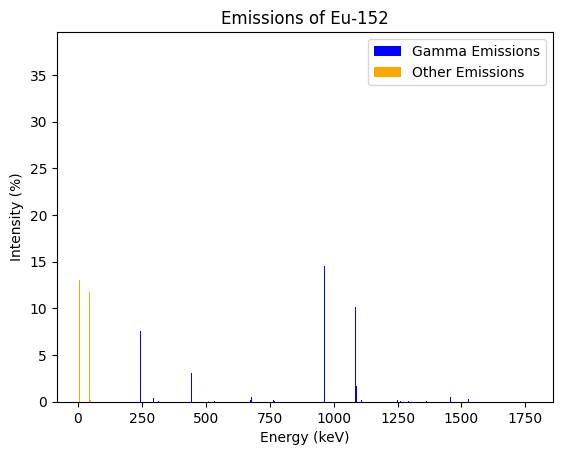

In [38]:
import matplotlib.pyplot as plt
plt.bar(g_energies, g_intensities, width=1, label ='Gamma Emissions', color='blue', alpha=1)
plt.bar(other_energies, other_intensities, width=1, label ='Other Emissions', color='orange', alpha=1)
plt.xlabel('Energy (keV)')
plt.ylabel('Intensity (%)')
plt.title(f'Emissions of {nuclide_name}')
# plt.yscale('log')
plt.legend()
plt.show()